In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(pheatmap)

In [3]:
library(ggpubr)

In [4]:
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [46]:
tumor <- read.table('Tumor.salmon.merged.gene_tpm.tsv',header=T)
normal <- read.table('Normal.salmon.merged.gene_tpm.tsv',header=T)

In [119]:
tumor_raw <- read.table('Tumor.salmon.merged.gene_counts.tsv',header=T)
normal_raw <- read.table('Normal.salmon.merged.gene_counts.tsv',header=T)

In [48]:
rownames(tumor) <- tumor$gene_id
rownames(normal) <- normal$gene_id

In [120]:
rownames(tumor_raw) <- tumor_raw$gene_id
rownames(normal_raw) <- normal_raw$gene_id

In [50]:
tumor <- tumor[,3:ncol(tumor)]
normal <- normal[,3:ncol(normal)]

In [121]:
tumor_raw <- tumor_raw[,3:ncol(tumor_raw)]
normal_raw <- normal_raw[,3:ncol(normal_raw)]

In [52]:
tumor %>% colnames() %>% str_replace('H','') %>% str_replace('T','') -> colnames(tumor)
normal %>% colnames() %>% str_replace('H','') %>% str_replace('N','') -> colnames(normal)

In [122]:
tumor_raw %>% colnames() %>% str_replace('H','') %>% str_replace('T','') -> colnames(tumor_raw)
normal_raw %>% colnames() %>% str_replace('H','') %>% str_replace('N','') -> colnames(normal_raw)

### remove 80% zeros

In [109]:
zero_percentage <- rowSums(tumor == 0) / ncol(tumor)
# Keep rows where the percentage of 0 values is less than the threshold
tumor_filtered <- tumor[zero_percentage < 1, ]


In [110]:
zero_percentage <- rowSums(normal == 0) / ncol(normal)
# Keep rows where the percentage of 0 values is less than the threshold
normal_filtered <- normal[zero_percentage < 1, ]


In [111]:
genes_intersect <- intersect(rownames(tumor_filtered),rownames(normal_filtered))

In [112]:
tumor_filtered <- tumor_filtered[genes_intersect,]
normal_filtered <- normal_filtered[genes_intersect,]

In [123]:
tumor_raw2 <- tumor_raw[genes_intersect,]
normal_raw2 <- normal_raw[genes_intersect,]

In [127]:
dim(tumor_filtered)
dim(normal_filtered)
dim(tumor_raw2)

[1] 22736    54

[1] 22736    54

[1] 22736    54

In [88]:
write.table(x = tumor,file = "tumor.tpm.txt",quote = F, sep="\t")
write.table(x = normal,file = "normal.tpm.txt",quote = F, sep="\t")

### save the data

In [129]:
saveRDS(object = tumor_filtered,file = "../00.data/Tumor.tpm.Rdata")
saveRDS(object = normal_filtered,file = "../00.data/Normal.tpm.Rdata")

In [130]:
saveRDS(object = tumor_raw2,file = "../00.data/Tumor.raw.Rdata")
saveRDS(object = normal_raw2,file = "../00.data/Normal.raw.Rdata")

### for cibersortx analysis

In [16]:
Tumor_celltype <- read.table('Tumor.CIBERSORTx_Results.txt',header=T,sep="\t",row.names=1)

In [17]:
Normal_celltype <- read.table('Normal.CIBERSORTx_Results.txt',header=T,sep="\t",row.names=1)

In [18]:
Tumor_celltype <- as.data.frame(t(Tumor_celltype))[1:22,]

In [19]:
Normal_celltype <- as.data.frame(t(Normal_celltype))[1:22,]

In [20]:
colnames(Tumor_celltype)%>% str_replace('H','') %>% str_replace('T','') -> colnames(Tumor_celltype)

In [21]:
colnames(Normal_celltype)%>% str_replace('H','') %>% str_replace('T','') -> colnames(Normal_celltype)

In [22]:
phe <- readRDS('phe_RNA54.Rdata')

In [23]:
High_group <- phe[phe$group == "High",]$sample
Low_group <- phe[phe$group == "Low",]$sample
Neg_group <- phe[phe$group == "negative",]$sample

In [24]:
group_info <- data.frame(name = c(High_group,Low_group,Neg_group),
                         group = c(rep('High',length(High_group)),
                                   rep("negative",length(Neg_group)),
                                    rep("Low",length(Low_group))))

In [25]:
Tumor_celltype2 <- Tumor_celltype[,group_info$name]

In [26]:
Normal_celltype2 <- Normal_celltype[,group_info$name]

In [27]:
rownames(group_info) <- group_info$name

In [28]:
group_info2 <- group_info

In [29]:
group_info2 <- group_info[,2,drop=FALSE]

In [30]:
options(repr.plot.height=6,repr.plot.width=8)
pheatmap(Tumor_celltype2,cluster_rows = F,cluster_cols = F,height = 6,width = 10,
         filename = "Tumor_celltype.heatmap.pdf",
         show_colnames = F,annotation_col = group_info2)

In [31]:
options(repr.plot.height=6,repr.plot.width=8)
pheatmap(Normal_celltype2,cluster_rows = F,cluster_cols = F,height = 6,width = 10,
         filename = "Normal_celltype.heatmap.pdf",
         show_colnames = F,annotation_col = group_info2)

In [37]:
Tumor_celltype2 <- Tumor_celltype[,group_info$name]
Tumor_celltype2$celltype <- rownames(Tumor_celltype2)
Tumor_celltype2_2 <- melt(Tumor_celltype2,id ='celltype')
Tumor_celltype2_2$group <- 'group'
Tumor_celltype2_2[Tumor_celltype2_2$variable %in% High_group,'group']  = 'High'
Tumor_celltype2_2[Tumor_celltype2_2$variable %in% Low_group,'group']  = 'Low'
Tumor_celltype2_2[Tumor_celltype2_2$variable %in% Neg_group,'group']  = 'Neg'

In [32]:
Normal_celltype2 <- Normal_celltype[,group_info$name]
Normal_celltype2$celltype <- rownames(Normal_celltype2)
Normal_celltype2_2 <- melt(Normal_celltype2,id ='celltype')
Normal_celltype2_2$group <- 'group'
Normal_celltype2_2[Normal_celltype2_2$variable %in% High_group,'group']  = 'High'
Normal_celltype2_2[Normal_celltype2_2$variable %in% Low_group,'group']  = 'Low'
Normal_celltype2_2[Normal_celltype2_2$variable %in% Neg_group,'group']  = 'Neg'

In [33]:
compare = list(c('High',"Low"),c("High","Neg"),c("Low","Neg"))

In [38]:
Tumor_celltype2_2$group <- factor(Tumor_celltype2_2$group,levels = c("High","Low","Neg"))

In [34]:
Normal_celltype2_2$group <- factor(Normal_celltype2_2$group,levels = c("High","Low","Neg"))

In [132]:
head(Tumor_celltype2_2)

,celltype,variable,value,group
,<chr>,<fct>,<dbl>,<fct>
1,B.cells.naive,9DW0073,0.1181433,High
2,B.cells.memory,9DW0073,0.2330651,High
3,Plasma.cells,9DW0073,0.0000000,High
4,T.cells.CD8,9DW0073,0.1181146,High
5,T.cells.CD4.naive,9DW0073,0.0000000,High
6,T.cells.CD4.memory.resting,9DW0073,0.2941304,High


In [40]:
options(repr.plot.height=16,repr.plot.width=16)
p_tumor2 <- ggboxplot(Tumor_celltype2_2,x="group",y="value",add="jitter",add.params=list(shape=21, fill="orange", size=3)
         )+geom_signif(comparisons = compare,step_increase = 0.1,map_signif_level = F,test = t.test
                      )+ylab("Proportion") + facet_wrap(~celltype, scale="free")

In [41]:
options(repr.plot.height=16,repr.plot.width=16)
p_normal2 <- ggboxplot(Normal_celltype2_2,x="group",y="value",add="jitter",add.params=list(shape=21, fill="orange", size=3)
         )+geom_signif(comparisons = compare,step_increase = 0.1,map_signif_level = F,test = t.test
                      )+ylab("Proportion") + facet_wrap(~celltype, scale="free")

Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (p_value < .Machine$double.eps) ...`:
! missing value where TRUE/FALSE needed”


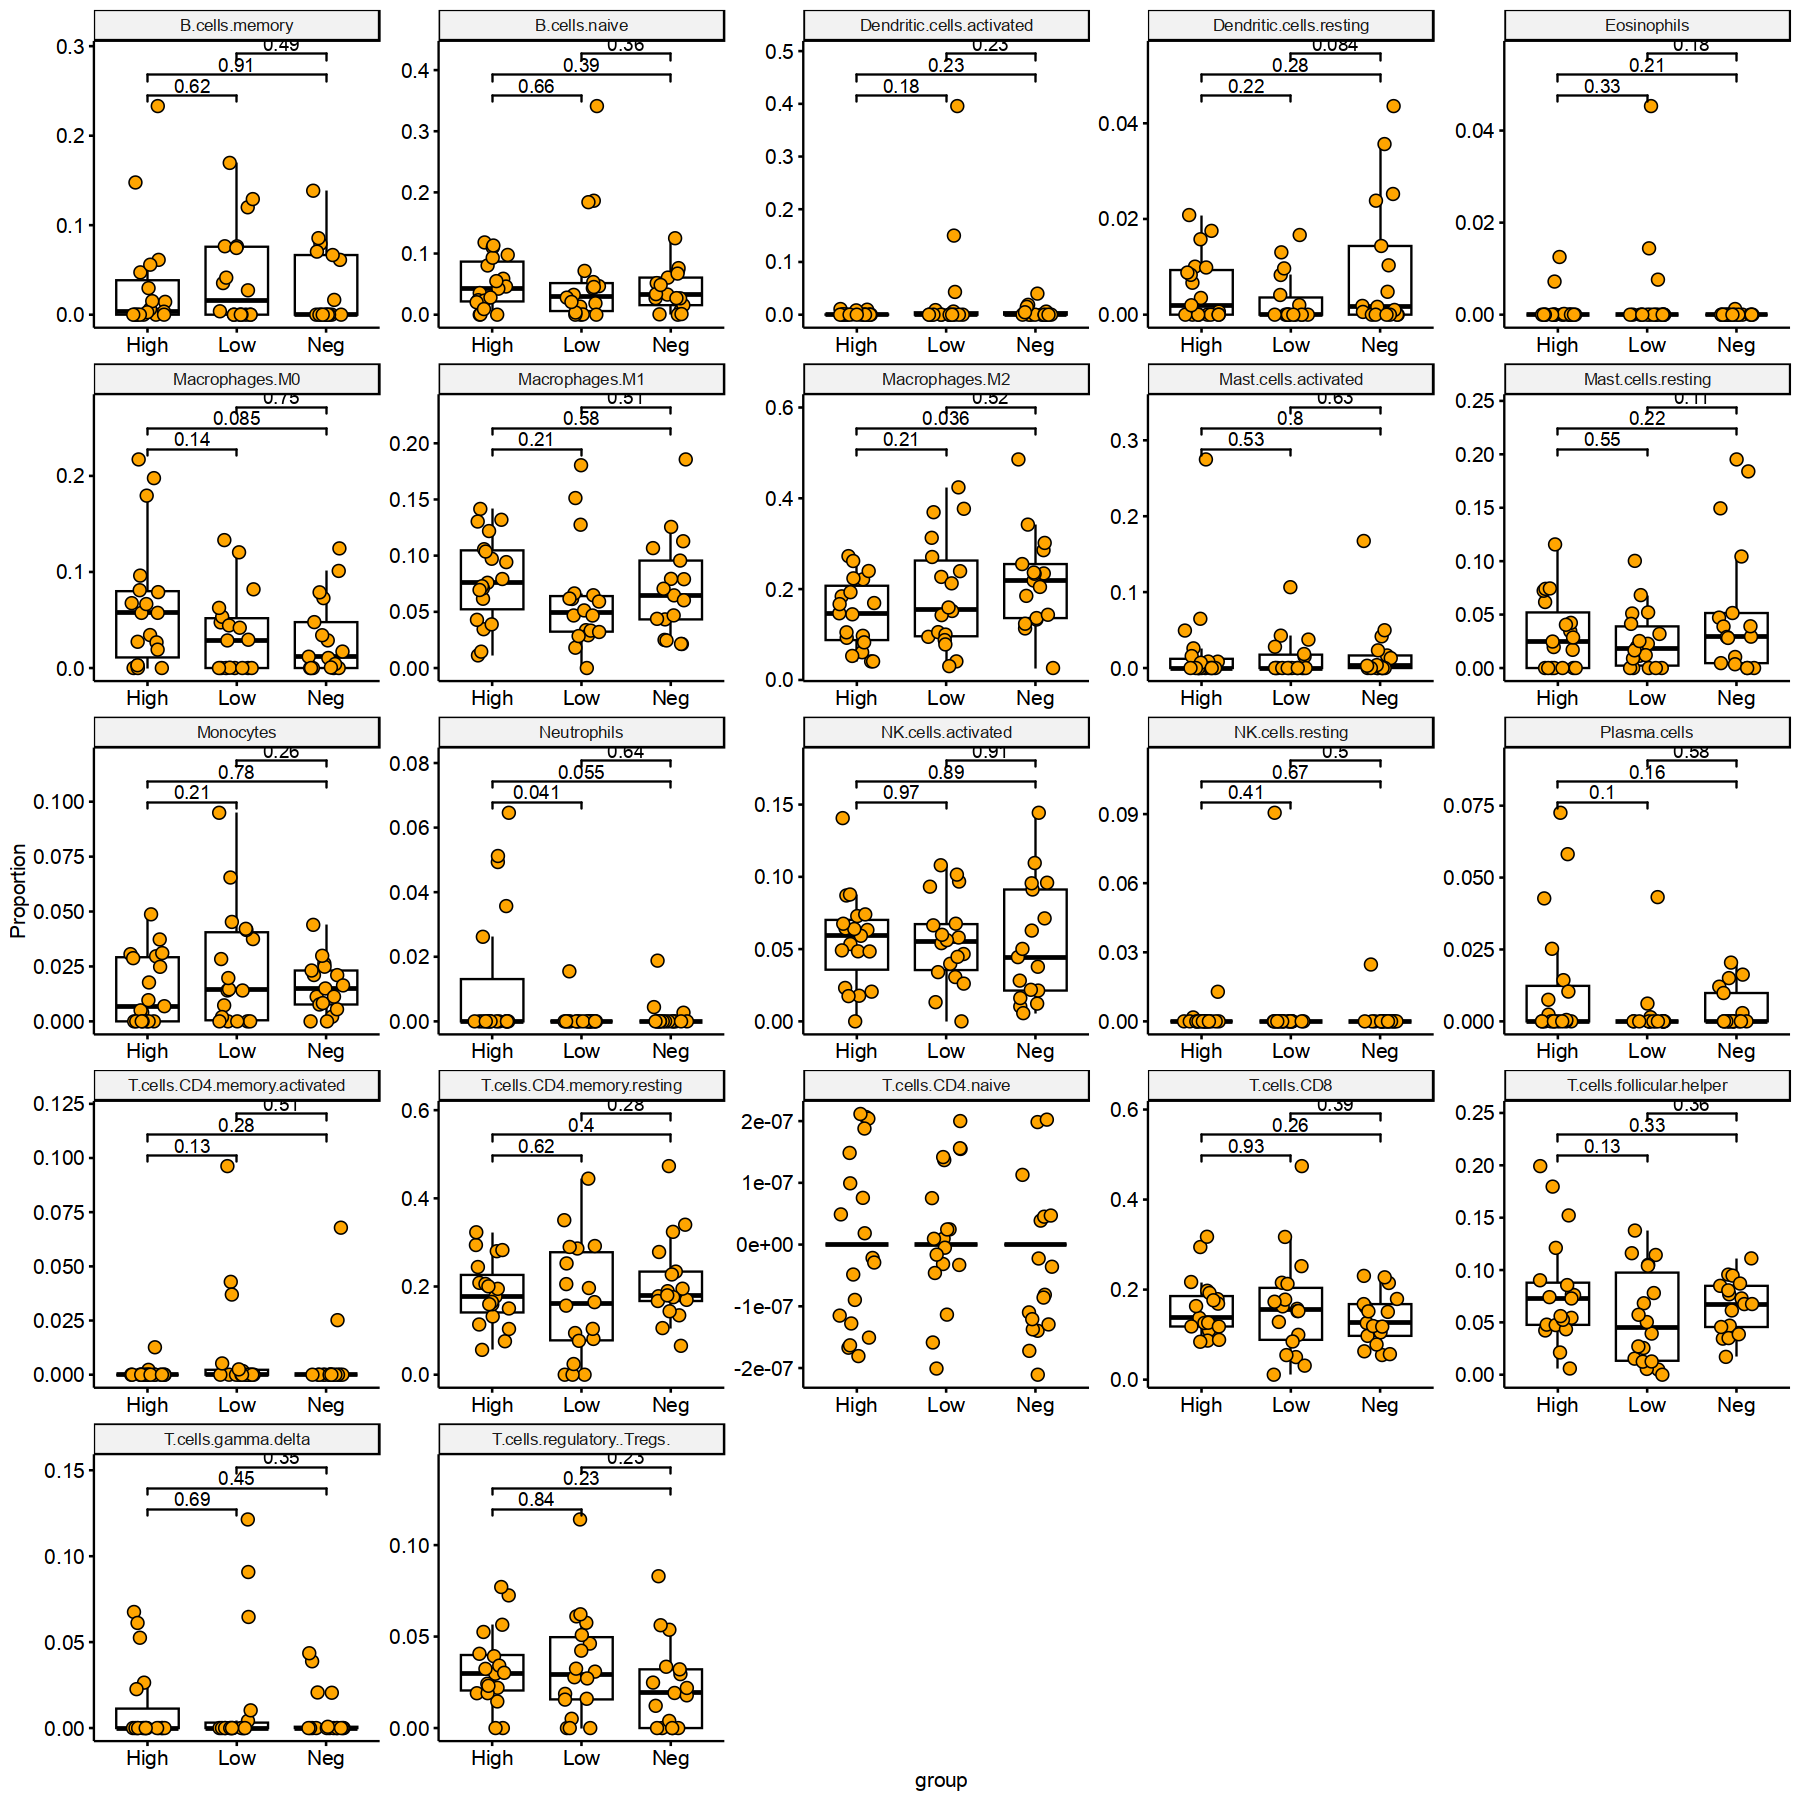

In [42]:
options(repr.plot.width = 15,repr.plot.height=15)
p_tumor2

Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (p_value < .Machine$double.eps) ...`:
! missing value where TRUE/FALSE needed”


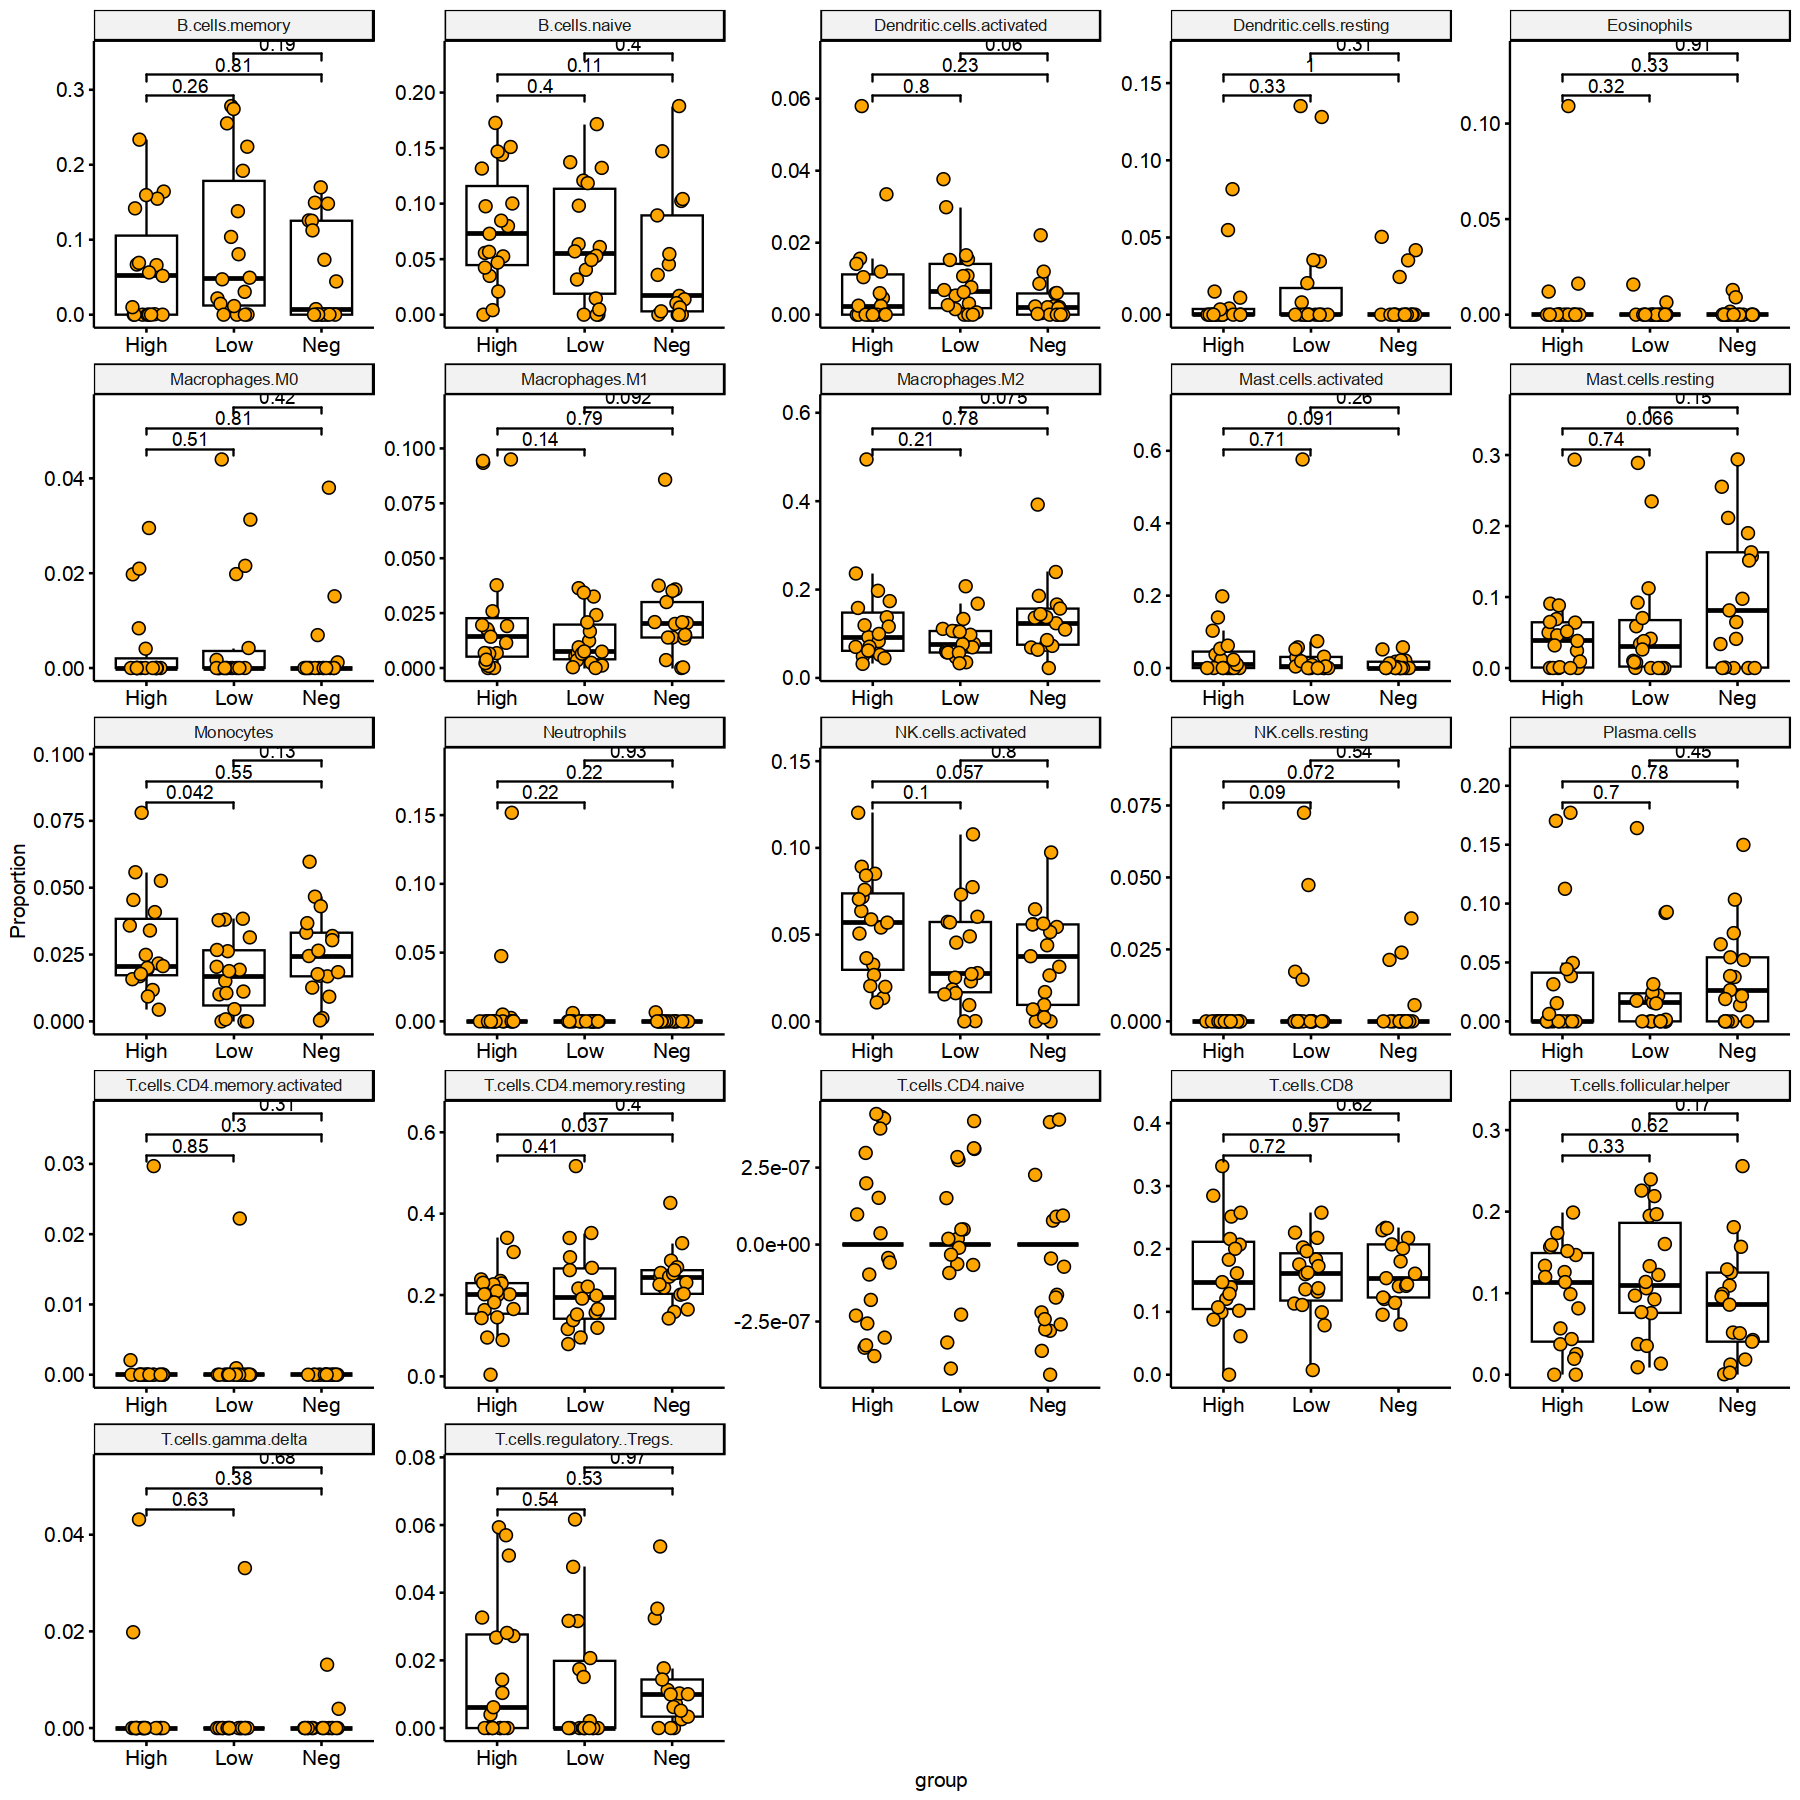

In [43]:
options(repr.plot.width = 15,repr.plot.height=15)
p_normal2

In [108]:
ggsave(filename = "Tumor_celltype.boxplot.pdf",plot =p_tumor2 ,width = 15,height = 15)

Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (p_value < .Machine$double.eps) ...`:
! missing value where TRUE/FALSE needed”


In [45]:
ggsave(filename = "Normal_celltype.boxplot.pdf",plot =p_normal2 ,width = 15,height = 15)

Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (p_value < .Machine$double.eps) ...`:
! missing value where TRUE/FALSE needed”
